In [1]:
# imports
import sys
import pandas as pd
from io import BytesIO
import numpy as np
sys.path.append('..')
import snowflake
import contextlib
from sqlalchemy import create_engine
from typing import List
from IPython.display import display
import okta1
# import dodb
pd.options.display.max_columns = None

# WMG Snowflake general
SNOWFLAKE_AUTHENTICATOR="https://wmg.okta.com"
SNOWFLAKE_ACCOUNT="wmg-datalab"

# Sodatone-specific
SNOWFLAKE_SODATONE_ROLE="ENT_OKTA_SNOWFLAKE_DATALAB_ATLANTIC"
SNOWFLAKE_SODATONE_WAREHOUSE="ATLANTIC_SANDBOX_WH_XS"



# --- CONFIG ---
# your okta email
SNOWFLAKE_OKTA_USER = okta1.e
# your okta password
SNOWFLAKE_OKTA_PASSWORD = okta1.p
def _get_engine(
        role: str,
        warehouse: str,
        user: str = SNOWFLAKE_OKTA_USER,
        password: str = SNOWFLAKE_OKTA_PASSWORD,
        account: str = SNOWFLAKE_ACCOUNT,
        authenticator: str = SNOWFLAKE_AUTHENTICATOR):
    return create_engine(
        _get_engine_url(role, warehouse, user, password, account),
        connect_args={
            # this will open your computer's default web-browser so you can auth with okta
            # then it will redirect to localhost with a token... that token is consumed by
            # the snowflake engine in order to authenticate queries
            # however, the engine needs to be recreated because of context decorator, so
            # sql queries should be grouped into an iterable of multiple statements to
            # prevent annoying window popups
            'authenticator': 'externalbrowser',
        },
    )

def _get_engine_url(role: str, warehouse: str, user: str, password: str, account: str) -> str:
    return (
        'snowflake://{user}:{password}@{account}/?warehouse={warehouse}&role={role}'.format(
            user=user,
            password=password,
            account=account,
            warehouse=warehouse,
            role=role,
        )
    )

@contextlib.contextmanager
def _get_conn(engine):
    conn = engine.connect()
    try:
        yield conn
    finally:
        conn.close()
        engine.dispose()

def _get_role_conn(role: str, warehouse: str):
    return _get_conn(_get_engine(role, warehouse))

def get_results_as_dfs(role: str, warehouse: str, sql_queries: List[str]) -> List[pd.DataFrame]:
    with _get_role_conn(role, warehouse) as conn:
        print(f"Running sql as {role} in warehouse: {warehouse}")
        return [pd.read_sql(x, conn) for x in sql_queries]

def get_sodatone_query_dfs(sql: List[str]):
    # sodatone specific
    return get_results_as_dfs(SNOWFLAKE_SODATONE_ROLE, SNOWFLAKE_SODATONE_WAREHOUSE, sql)
def get_results_as_df(role: str, warehouse: str, sql_query: str) -> pd.DataFrame:
    with _get_role_conn(role, warehouse) as conn:
        print(f"Running sql as {role} in warehouse: {warehouse}")
        return pd.read_sql(sql_query, conn)
    
def get_sodatone_query_df(sql: str):
    # sodatone specific
    return get_results_as_df(SNOWFLAKE_SODATONE_ROLE, SNOWFLAKE_SODATONE_WAREHOUSE, sql)

In [2]:
query = '''WITH joined AS (
  SELECT
    m.ARTIST,
    m.TITLE,
    m.UNIFIED_SONG_ID,
    m.DATE,
    t.RELEASE_DATE,
    m.THIS_DAY,
    m.THIS_WEEK,
    m.DATE - CAST(t.RELEASE_DATE AS DATE) AS DAYS_SINCE_RELEASE,
    (DAYOFWEEK(m.DATE) + 2) % 7 AS day_of_week
  FROM
    "SODATONE"."SODATONE"."LUMINATE_DAILY_SONG_METRICS" AS m
  JOIN
    "APP_REACT"."JOHN_S"."FINAL_TRACKS" AS t ON m.UNIFIED_SONG_ID = t.UNIFIED_SONG_ID
  WHERE
    m.METRIC_TYPE = 'Streaming On-Demand Audio'
    AND m.REGION = 'us'
    AND m.DATE > '2024-05-01'
),
lag AS (
  SELECT *,
     THIS_DAY AS day_0,
     LAG(THIS_DAY, 1, NULL) OVER(PARTITION BY UNIFIED_SONG_ID ORDER BY DATE ASC) AS day_1,
     LAG(THIS_DAY, 2, NULL) OVER(PARTITION BY UNIFIED_SONG_ID ORDER BY DATE ASC) AS day_2,
     LAG(THIS_DAY, 3, NULL) OVER(PARTITION BY UNIFIED_SONG_ID ORDER BY DATE ASC) AS day_3,
     LAG(THIS_DAY, 4, NULL) OVER(PARTITION BY UNIFIED_SONG_ID ORDER BY DATE ASC) AS day_4,
     LAG(THIS_DAY, 5, NULL) OVER(PARTITION BY UNIFIED_SONG_ID ORDER BY DATE ASC) AS day_5,
     LAG(THIS_DAY, 6, NULL) OVER(PARTITION BY UNIFIED_SONG_ID ORDER BY DATE ASC) AS day_6,
     THIS_WEEK AS week_0,
     LAG(THIS_WEEK, 7, NULL) OVER(PARTITION BY UNIFIED_SONG_ID ORDER BY DATE ASC) AS week_1,
     LAG(THIS_WEEK, 14, NULL) OVER(PARTITION BY UNIFIED_SONG_ID ORDER BY DATE ASC) AS week_2,
     LAG(THIS_WEEK, 21, NULL) OVER(PARTITION BY UNIFIED_SONG_ID ORDER BY DATE ASC) AS week_3,
     LEAD(THIS_DAY, 1, NULL) OVER(PARTITION BY UNIFIED_SONG_ID ORDER BY DATE ASC) AS target
  FROM joined
)
SELECT *,
FROM lag
WHERE
    --DATE = (SELECT MAX(DATE) FROM joined)
    DAYS_SINCE_RELEASE > 0
    AND target IS NOT NULL
ORDER BY UNIFIED_SONG_ID, DATE DESC
LIMIT 5000;'''

In [12]:
df = get_sodatone_query_df(query)
df

Initiating login request with your identity provider. A browser window should have opened for you to complete the login. If you can't see it, check existing browser windows, or your OS settings. Press CTRL+C to abort and try again...
Going to open: https://wmg.okta.com/app/snowflake/exkab0aaa1IEBMlNX2p7/sso/saml?SAMLRequest=jZJRb9owFIX%2FSuQ9J3YCa6kFVFDKitR2FNJp4s1JTPDi2Kmv08C%2Fn0OgYg%2Bt9mbZ5%2Fi79547vN2X0nvnBoRWIxQGBHlcpToTKh%2Bh13juD5AHlqmMSa34CB04oNvxEFgpKzqp7U6t%2BFvNwXruIwW0fRih2iiqGQigipUcqE3pevL0SKOAUAbAjXU4dLJkIBxrZ21FMW6aJmh6gTY5jgghmNxgp2ol39AFovqaURltdarl2bJ3PX2CCDHptwincITlyTgVqhvBV5SkEwF9iOOlv%2Fy5jpE3OXd3pxXUJTdrbt5Fyl9Xj10B0FZQ5n7GLJMsCUDpZitZwVNdVrV1%2FwXuhLc8w1Lnwk1pMRuhqhBZtEqk3TQPEbnf9JKkfFl9Z8vpoLZ%2FDrl8206t6P3YzeNiFhUp8n6dM43aTBcANV%2BoNknrrkjU98mVHw5iQii5puQqIP1wg7yZS1IoZo%2FOi3IDXVh2LIxVFf6oGfN9wRLCGAsX99Mn%2Bfw7qq4xgMZtSKjbE3qEm%2FH%2Fdz%2FEl77Tsj27%2BS9mSy1FevDm2pTMfh5PGITHG5H526OU8pIJOckywwFcTFLq5s5wZt1OW1NzhMcd9d%2BtHv8F&RelayState=58681 to authenticate...

,artist,title,unified_song_id,date,release_date,this_day,this_week,days_since_release,day_of_week,day_0,day_1,day_2,day_3,day_4,day_5,day_6,week_0,week_1,week_2,week_3,target
0,Young Thug,Hercules,100070,2024-06-14,2016-02-05,16004,103313.0,3052,0,16004,15999.0,15412.0,15053.0,13938.0,12305.0,14530.0,103313.0,101589.0,100364.0,102812.0,12863
1,Young Thug,Hercules,100070,2024-06-13,2016-02-05,15999,101589.0,3051,6,15999,15412.0,15053.0,13938.0,12305.0,14530.0,16076.0,101589.0,100364.0,103225.0,103165.0,16004
2,Young Thug,Hercules,100070,2024-06-12,2016-02-05,15412,101589.0,3050,5,15412,15053.0,13938.0,12305.0,14530.0,16076.0,15357.0,101589.0,100364.0,103225.0,103165.0,15999
3,Young Thug,Hercules,100070,2024-06-11,2016-02-05,15053,101589.0,3049,4,15053,13938.0,12305.0,14530.0,16076.0,15357.0,15191.0,101589.0,100364.0,103225.0,103165.0,15412
4,Young Thug,Hercules,100070,2024-06-10,2016-02-05,13938,101589.0,3048,3,13938,12305.0,14530.0,16076.0,15357.0,15191.0,14927.0,101589.0,100364.0,103225.0,103165.0,15053
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,Ed Sheeran,Sing,6293132,2024-05-25,2014-01-01,44570,295306.0,3797,1,44570,46720.0,45718.0,47668.0,41631.0,38102.0,34823.0,295306.0,308712.0,255995.0,284499.0,38688
4996,Ed Sheeran,Sing,6293132,2024-05-24,2014-01-01,46720,295306.0,3796,0,46720,45718.0,47668.0,41631.0,38102.0,34823.0,41448.0,295306.0,308712.0,255995.0,284499.0,44570
4997,Ed Sheeran,Sing,6293132,2024-05-23,2014-01-01,45718,308713.0,3795,6,45718,47668.0,41631.0,38102.0,34823.0,41448.0,45920.0,308713.0,255995.0,284499.0,301547.0,46720
4998,Ed Sheeran,Sing,6293132,2024-05-22,2014-01-01,47668,308713.0,3794,5,47668,41631.0,38102.0,34823.0,41448.0,45920.0,45187.0,308713.0,255995.0,284499.0,NaN,45718


In [20]:
df

,days_since_release,day_of_week,day_0,day_1,day_2,day_3,day_4,day_5,day_6,target
0,3052,0,16004,15999.0,15412.0,15053.0,13938.0,12305.0,14530.0,12863
1,3051,6,15999,15412.0,15053.0,13938.0,12305.0,14530.0,16076.0,16004
2,3050,5,15412,15053.0,13938.0,12305.0,14530.0,16076.0,15357.0,15999
3,3049,4,15053,13938.0,12305.0,14530.0,16076.0,15357.0,15191.0,15412
4,3048,3,13938,12305.0,14530.0,16076.0,15357.0,15191.0,14927.0,15053
...,...,...,...,...,...,...,...,...,...,...
4995,3797,1,44570,46720.0,45718.0,47668.0,41631.0,38102.0,34823.0,38688
4996,3796,0,46720,45718.0,47668.0,41631.0,38102.0,34823.0,41448.0,44570
4997,3795,6,45718,47668.0,41631.0,38102.0,34823.0,41448.0,45920.0,46720
4998,3794,5,47668,41631.0,38102.0,34823.0,41448.0,45920.0,45187.0,45718


In [21]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt


new_df = df[['days_since_release', 'day_of_week', 'day_0', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'target']]
new_df = df.dropna()


X = new_df.drop('target', axis=1)  # Replace with your target column name
y = new_df['target']

# Split data into training and testing sets (test_size=0.1 for 10% test data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Create the linear regression model
model = LinearRegression()

# Train the model on the training data
model.fit(X_train, y_train)

# Use the trained model to make predictions on the test data
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

train_mse = mean_squared_error(y_train_pred, y_train)
test_mse = mean_squared_error(y_test_pred, y_test)

print("Train MSE: ", train_mse)
print("Test MSE: ", test_mse)

Train MSE:  25315665.88189172
Test MSE:  38406963.249498665


<AxesSubplot:ylabel='target'>

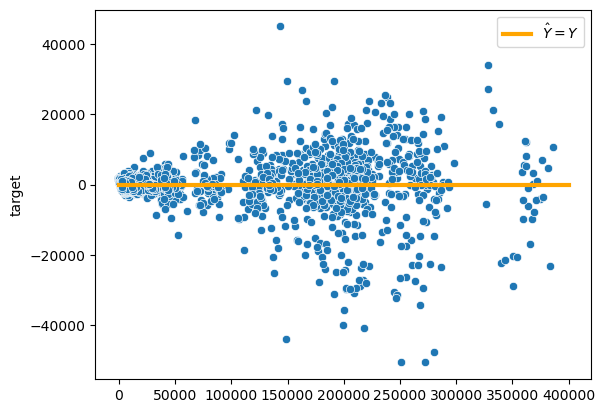

In [29]:
sns.scatterplot(x = y_train_pred, y = y_train - y_train_pred)
sns.lineplot(x=[-1, 400000], y=[0,0], label="$\hat{Y}=Y$", color = 'orange', linewidth = 3)

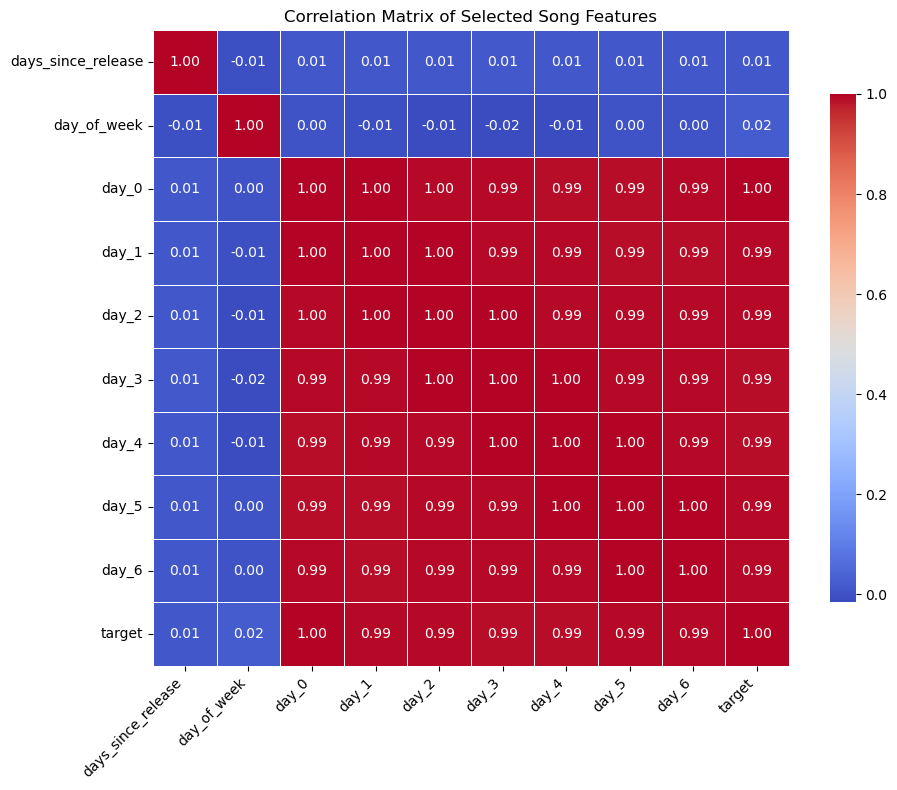

In [8]:
correlation_matrix = df.corr()

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=.5, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix of Selected Song Features')
plt.xticks(rotation=45, ha='right')  # Rotate feature names for better readability
plt.yticks(rotation=0)
plt.tight_layout()  # Adjust layout to prevent clipping of tick labels
plt.show()